In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('once')
from sklearn.tree import DecisionTreeRegressor
import datetime as dt
import pickle

In [2]:
df = pd.read_csv('../datos/registrados/06-registrados-cod_est.csv', index_col=0)
df.head(2)

,atemp,hum,windspeed,dteday,season,yr,mnth,holiday,weekday,weathersit,registered
0,-0.456399,0.855582,-0.208909,2018-01-01,0,0,0,0,0,1,654
1,-0.492863,0.332722,0.687550,2018-01-02,0,0,0,1,1,1,670


In [3]:
df.dtypes

atemp         float64
hum           float64
windspeed     float64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
weathersit      int64
registered      int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atemp       730 non-null    float64
 1   hum         730 non-null    float64
 2   windspeed   730 non-null    float64
 3   dteday      730 non-null    object 
 4   season      730 non-null    int64  
 5   yr          730 non-null    int64  
 6   mnth        730 non-null    int64  
 7   holiday     730 non-null    int64  
 8   weekday     730 non-null    int64  
 9   weathersit  730 non-null    int64  
 10  registered  730 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 68.4+ KB


In [5]:
df.head(2)

,atemp,hum,windspeed,dteday,season,yr,mnth,holiday,weekday,weathersit,registered
0,-0.456399,0.855582,-0.208909,2018-01-01,0,0,0,0,0,1,654
1,-0.492863,0.332722,0.687550,2018-01-02,0,0,0,1,1,1,670


In [6]:
df.drop(['dteday'], axis = 1, inplace=True)

In [7]:
df.head(2)

,atemp,hum,windspeed,season,yr,mnth,holiday,weekday,weathersit,registered
0,-0.456399,0.855582,-0.208909,0,0,0,0,0,1,654
1,-0.492863,0.332722,0.687550,0,0,0,1,1,1,670


---

In [8]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [10]:
arbol = DecisionTreeRegressor(random_state =0)
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

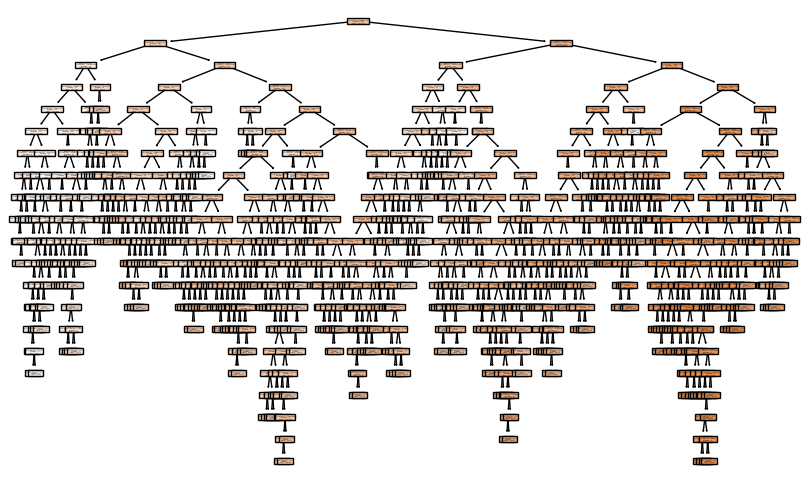

In [11]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [12]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [13]:
print(arbol.tree_.max_depth)

20


In [14]:
param = {"max_depth": [4,6,8,10],
        "max_features": [1,2,3,4],
        "min_samples_split": [10,40,70],
        "min_samples_leaf": [10,40,70]} 

In [15]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error")
gs.fit(x_train, y_train)



GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 40, 70],
                         'min_samples_split': [10, 40, 70]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [16]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=10, max_features=4, min_samples_leaf=10,
                      min_samples_split=40)

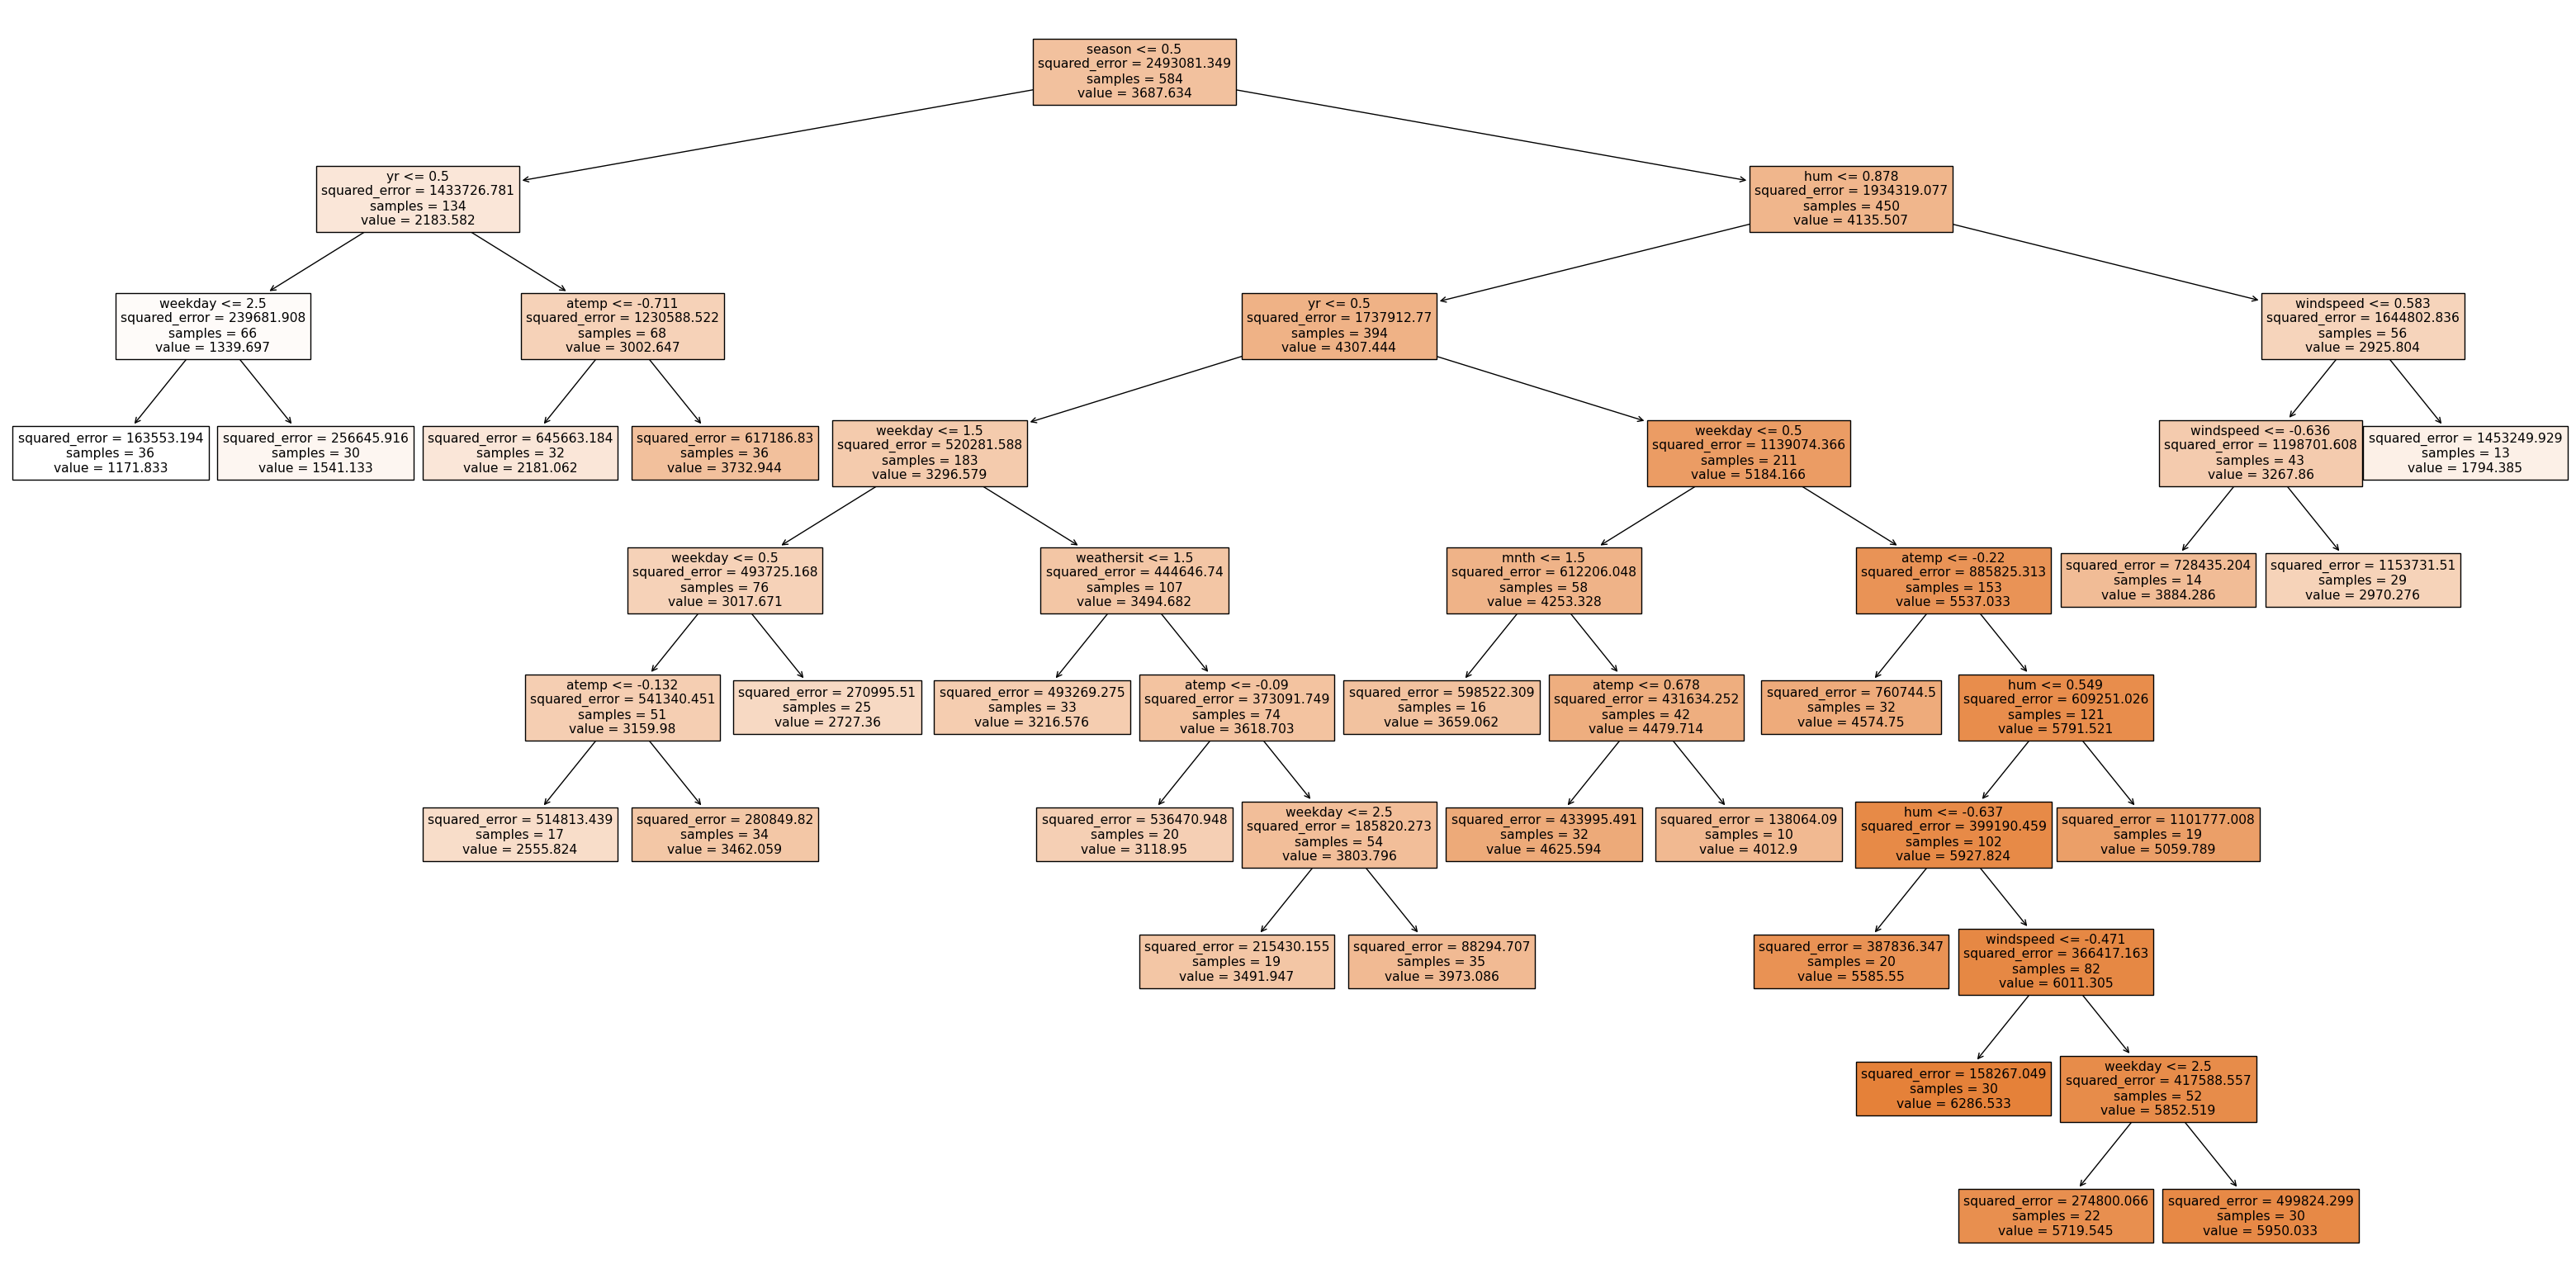

In [17]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [18]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [19]:

def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [20]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "2_Decision_tree_estand")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,541.042567,468324.969981,684.342728,0.783039,test,2_Decision_tree_estand
1,520.166777,482790.596444,694.831344,0.806348,train,2_Decision_tree_estand


Random forest

In [21]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
param = {"max_depth": [4,6,8,10],
        "max_features": [1,2,3,4],
        "min_samples_split": [10,40,70],
        "min_samples_leaf": [10,40,70]} 

In [24]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 


In [25]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 40, 70],
                         'min_samples_split': [10, 40, 70]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [26]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=10, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [27]:
'''for arbol in tqdm(bosque.estimators_):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
    plt.show()'''

'for arbol in tqdm(bosque.estimators_):\n    fig = plt.figure(figsize=(40, 20))\n    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)\n    plt.show()'

In [28]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
   
   
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df


In [29]:
dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "2_Random Forest_estand")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,452.155887,325061.107919,570.141305,0.849409,test,2_Random Forest_estand
1,463.250276,386935.834385,622.041666,0.844796,train,2_Random Forest_estand


In [30]:
df_todos_resultados = pd.concat([dt_results, dt_results1], axis = 0)
df_todos_resultados


,MAE,MSE,RMSE,R2,set,modelo
0,452.155887,325061.107919,570.141305,0.849409,test,2_Random Forest_estand
1,463.250276,386935.834385,622.041666,0.844796,train,2_Random Forest_estand
0,541.042567,468324.969981,684.342728,0.783039,test,2_Decision_tree_estand
1,520.166777,482790.596444,694.831344,0.806348,train,2_Decision_tree_estand


In [31]:
df_todos_resultados.to_csv('../datos/registrados/07-registrados_metricas_estandar.csv')

# Random Forest es la mejor opcion

In [32]:
with open('../datos/registrados/07_decision_registered.pkl','wb') as fp:
    pickle.dump(arbol,fp)

In [33]:
with open('../datos/registrados/07_random_casual.pkl','wb') as fp:
    pickle.dump(bosque,fp)